<a href="https://colab.research.google.com/github/sliplr19/DS5001/blob/main/4_5_Assignment_2_Designing_CNN_Architecture_to_recognize_UVA_Historical_Landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assignment 2: Designing an Architecture for Recognizing UVA Historical Landmarks
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

In this assignment, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 100 points for this assignment if you successfully transfer at least 3 existing architectures, plus 10 bonus points if your classifier performance exceeds 94% accuracy.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Canvas with the following format: yourcomputingID_assignment_2.ipynb

Best of luck, and have fun!

## TA's notes
Requirements:
- You must be able to implement a complete training/validation loop with a final test. The basic logic is similar to the FashionMNIST in previous tutorials.
- You must use 3 models. You could create/train all models from scratch or you can use transfer learning (for example, torchvision.models.resnet18) for one, two, or all of them. You may find CNN-specific architectures (e.g., LeNet, AlexNet, ResNet variants, GoogLeNet, VGG, etc) will be helpful. The most widely used CNN architectures include VGG-16 and ResNet-FPN-X101 (but they may be too big for Google Colab GPUs, so try small variants if that's the case). You could also try state-of-the-art Vision Transformers (ViT) but it's technically not a CNN so the rest of your models must both be CNN. ViTs might also be too big for the Google Colab GPUs. The above-mentioned architectures all have pretrained versions in [torchvision](https://pytorch.org/vision/stable/models.html).
- You can use the Sequential model creation instead of the class API, but that can make adding/changing various modules more difficult.
- Please split your own validation set. We've done this in previous tutorials also.
- Please do NOT change the random `SEED` or the test dataset/dataloader so I can verify your performance.
- Please also plot your training and loss curves. This way you and I will both understand the learning process and identify any problem.
- Please make your 3 models sufficiently different. For example, it's not enough to add one layer and call that a different model.

# Load Packages

In [5]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch


# Random Seed for Reproduction

In [6]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [7]:
# Download dataset from FirebaseStorage
!curl -L "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7" -o "dataset.zip"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  378M  100  378M    0     0   128M      0  0:00:02  0:00:02 --:--:--  128M


In [8]:
# Extract content
!unzip -q "dataset.zip"

In [9]:
from sklearn.datasets import load_files

data_dir = "dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150;
img_width = 150;


In [10]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder


TEST_RATIO = 0.2
BATCH_SIZE = 32

# Download and load the training data
dataset_all = ImageFolder(
    data_dir,
    transform=ToTensor(),
)

size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train, dataset_test = random_split(dataset_all, [size_train, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_test)={len(dataset_test)}')

# NOTE that you must not use the test dataset for model selection


Before splitting the full dataset into train and test: len(dataset_all)=14286
After splitting the full dataset into train and test: len(dataset_train)=11429. len(dataset_test)=2857


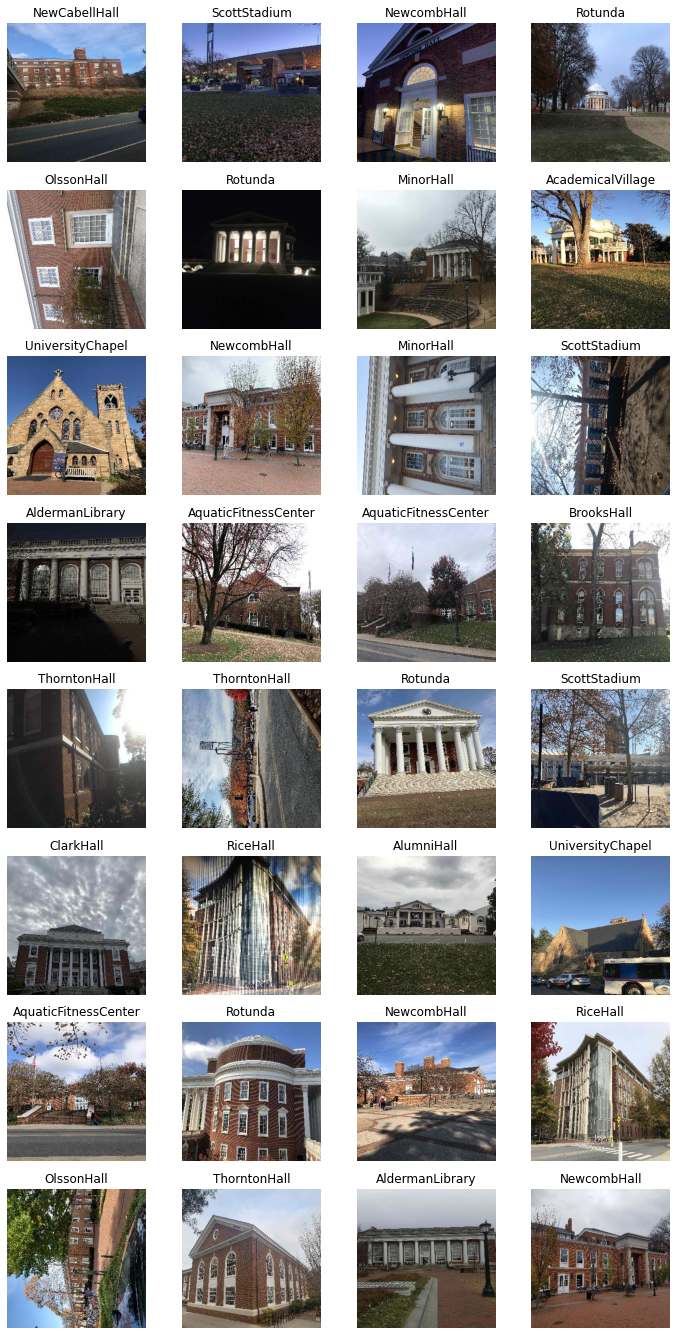

In [ ]:
from torchvision.transforms.functional import to_pil_image


# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

plt.show()

# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks.

Best of luck!

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyCNN1(nn.Module):
    def __init__(self, num_classes=10, padding="same"):
        super().__init__()

        pad_mode = 1 if padding == "same" else 0

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block 1
        self.conv2a = nn.Conv2d(64, 64, kernel_size=3, padding=pad_mode)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=pad_mode)
        self.bn2b = nn.BatchNorm2d(64)

        # Residual block 2
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=pad_mode, stride=2)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=pad_mode)
        self.bn3b = nn.BatchNorm2d(128)
        self.shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2),
            nn.BatchNorm2d(128)
        )

        # Global pooling and fully connected layer
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Initial convolution
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Residual block 1
        identity = x
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = self.bn2b(self.conv2b(x))
        x += identity
        x = F.relu(x)

        # Residual block 2
        identity = self.shortcut(x)
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = self.bn3b(self.conv3b(x))
        x += identity
        x = F.relu(x)

        # Global pooling and fully connected layer
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [25]:

class MyCNN2(nn.Module):
    def __init__(self, num_classes=10, use_depthwise=False, padding="same"):
        super().__init__()

        pad_mode = 1 if padding == "same" else 0

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=pad_mode)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=pad_mode)

        if use_depthwise:
            self.depthwise = nn.Conv2d(64, 64, kernel_size=3, padding=pad_mode, groups=64)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.maxpool(X)

        X = F.relu(self.conv2(X))
        X = self.avgpool(X)

        if hasattr(self, 'depthwise'):
            X = F.relu(self.depthwise(X))

        X = self.global_avgpool(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)

        return X


In [26]:
class MyCNN3(nn.Module):
    def __init__(self, num_classes=10, padding="same"):
        super().__init__()

        pad_mode = 1 if padding == "same" else 0

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=pad_mode)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=pad_mode)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=pad_mode)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=pad_mode)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=pad_mode)
        self.bn5 = nn.BatchNorm2d(128)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout3 = nn.Dropout(0.5)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout3(x)

        x = self.fc(x)

        return x






In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import copy


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    history = {
        'train_loss': [],
        'train_acc': []
    }

    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

    print()

    return model, history

def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics

def plot_learning_curves(histories, model_names):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')

    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history['train_acc']) + 1)

        ax[0].plot(epochs, history['train_acc'], 'o-', label=f'{name} Train')

        ax[1].plot(epochs, history['train_loss'], 'o-', label=f'{name} Train')

    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

def main(dataset_train, dataset_test):

    batch_size = 32
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

    num_classes = 32
    print(f"Using {num_classes} classes for classification")

    models = [
        MyCNN1(num_classes=num_classes),
        MyCNN2(num_classes=num_classes),
        MyCNN3(num_classes=num_classes)
    ]

    model_names = ['MyCNN1', 'MyCNN2', 'MyCNN3']

    num_epochs = 10
    criterion = nn.CrossEntropyLoss()

    histories = []
    test_metrics = []

    for i, (model, name) in enumerate(zip(models, model_names)):
        print(f"\nTraining {name}...")

        optimizer = optim.Adam(model.parameters(), lr=0.001)

        trained_model, history = train_model(
            model, train_loader, criterion, optimizer,
            num_epochs=num_epochs)

        metrics = evaluate_model(trained_model, test_loader)

        histories.append(history)
        test_metrics.append(metrics)

        print(f"\n{name} Test Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    plot_learning_curves(histories, model_names)

    print("\nTest Metrics Comparison:")
    for i, name in enumerate(model_names):
        print(f"\n{name}:")
        for metric, value in test_metrics[i].items():
            print(f"{metric}: {value:.4f}")

    return models, histories, test_metrics






Using device: cpu


In [ ]:
main(dataset_train, dataset_test)

Using 32 classes for classification

Training MyCNN1...
Epoch 1/10
----------
Loss: 2.3179 Acc: 0.2887
Epoch 2/10
----------
Loss: 1.8425 Acc: 0.4545
Epoch 3/10
----------
